In [79]:
from sketch import CountMinSketch, CountSketch
import sketch
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

import importlib
import math

importlib.reload(sketch)

<module 'sketch' from '/home/ericwang/diffsketch/sketch.py'>

In [ ]:
eps = 0.0001
delta = 1 / 2 ** 10

# Count Min Sketch
w = math.ceil(2 / eps)
d = math.ceil(math.log(1 / delta, 2))

# # Count Sketch
# w = math.ceil(math.e / eps ** 2)
# d = math.ceil(math.log(1 / delta))

print(f"w = {w}, d = {d} with eps = {eps}, delta = {delta}")

cm = CountMinSketch(d=d, w=w)

df: pl.DataFrame = pl.read_csv("/data1/caida_data/caida_nf/equinix-nyc.dirA.20180419-133000.UTC.anon.pcap_Flow.csv", columns=["Flow ID", "Total Fwd Packet"])

keys = df.get_column("Flow ID")
updates = df.get_column("Total Fwd Packet")

cm.insert(df)

estimates = cm.query(keys.unique())

estimates_df = pl.DataFrame({
    "flow": keys.unique(),
    "estimates": estimates
})

actual = df.group_by("Flow ID").sum().select(flow=pl.col('Flow ID'), packets=pl.col("Total Fwd Packet"))

abs_diff = (pl.col("packets") - pl.col("estimates")).abs()
expr = abs_diff / pl.col("packets") + 1
diffs = actual.join(estimates_df, on="flow", how="left").with_columns(error=expr, abs_diff=abs_diff)

w = 20000, d = 10 with eps = 0.0001, delta = 0.0009765625


In [126]:
m = diffs['packets'].sum()
expected_diff = eps * m
print(f"Expected Error (Absolute Difference): {expected_diff}")
print(f"Length of Data Stream: {m}")
diffs.describe()

Expected Error (Absolute Difference): 3276.3031
Length of Data Stream: 32763031


statistic,flow,packets,estimates,error,abs_diff
str,str,f64,f64,f64,f64
"""count""","""923690""",923690.0,923690.0,923690.0,923690.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,35.469726,376.62933,83.926647,378.765331
"""std""",null,646.211567,652.264978,163.614948,903.545573
"""min""","""1.129.134.79-16.233.88.217-451…",2.0,128.0,1.0,0.0
"""25%""",null,3.0,290.0,33.375,278.0
"""50%""",null,6.0,340.0,62.166667,330.0
"""75%""",null,10.0,403.0,114.333333,395.0
"""max""","""99.99.14.200-205.70.213.244-51…",406108.0,406331.0,53609.5,406319.0


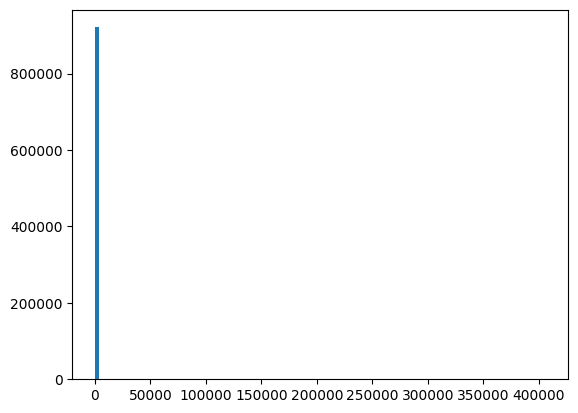

In [128]:
plt.hist(diffs['abs_diff'], bins=100)
plt.show()

In [121]:
percentile = 0.1
num_flows = int(len(diffs) * percentile)
diffs.sort(by='packets')[-num_flows:].describe()

statistic,flow,packets,estimates,error,abs_diff
str,str,f64,f64,f64,f64
"""count""","""92369""",92369.0,92369.0,92369.0,92369.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,298.734608,377.468382,8.369297,454.717708
"""std""",null,2024.537932,579.338358,21.341143,2058.851347
"""min""","""100.109.204.77-205.126.37.150-…",23.0,121.0,1.0,0.0
"""25%""",null,26.0,289.0,2.207143,208.0
"""50%""",null,48.0,339.0,7.016667,281.0
"""75%""",null,155.0,402.0,12.111111,361.0
"""max""","""99.98.0.249-207.1.126.97-8999-…",406108.0,107240.0,4662.608696,405789.0


In [110]:
num_flows

92369

In [116]:
cm.table[0].sum(), df['Total Fwd Packet'].sum()

(np.float64(32763031.0), 32763031)